In [1]:
# Cell 1: Imports and configurations
import os
import xml.etree.ElementTree as ET
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2, efficientnet_b0
import torchvision.models.detection as detection_models

# Check device

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility (optional)
torch.manual_seed(42)


CUDA available: True
CUDA device count: 1
Current CUDA device: NVIDIA GeForce RTX 4060


In [2]:
def parse_annotation(xml_file, label_map):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        cls_name = obj.find('name').text.strip()
        label = label_map.get(cls_name)
        if label is None:
            continue
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    
    # Ensure boxes is a numpy array of shape [N, 4]
    boxes = np.array(boxes, dtype=np.float32)
    if boxes.ndim != 2:
        boxes = np.empty((0, 4), dtype=np.float32)
    return {"boxes": boxes, "labels": labels}

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

def create_classification_dataset(images_dir, annotations_dir, output_dir):
    # Define the classes based on your annotation
    classes = ["with_mask", "without_mask", "mask_weared_incorrect"]
    
    # Create output directories if they do not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for cls in classes:
        cls_dir = os.path.join(output_dir, cls)
        if not os.path.exists(cls_dir):
            os.makedirs(cls_dir)
    
    # Iterate over every XML file in the annotations folder.
    ann_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
    for ann_file in ann_files:
        xml_path = os.path.join(annotations_dir, ann_file)
        try:
            tree = ET.parse(xml_path)
        except Exception as e:
            print(f"Error parsing {xml_path}: {e}")
            continue
        root = tree.getroot()
        
        # Get the filename from XML.
        filename = root.find('filename').text.strip()
        img_path = os.path.join(images_dir, filename)
        # Open the image.
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            continue
        
        # Process all objects in the XML.
        for obj in root.findall('object'):
            cls_name = obj.find('name').text.strip()
            if cls_name not in classes:
                continue   # Skip unrecognized classes.
            
            # Get bounding box from XML.
            bndbox = obj.find('bndbox')
            try:
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
            except Exception as e:
                print(f"Error reading bounding box in {xml_path}: {e}")
                continue
            
            cropped = img.crop((xmin, ymin, xmax, ymax))
            # Create a unique filename for the cropped image.
            base = os.path.splitext(filename)[0]
            out_filename = f"{base}_{cls_name}_{xmin}_{ymin}.png"
            out_path = os.path.join(output_dir, cls_name, out_filename)
            cropped.save(out_path)

    print("Classification dataset created at:", output_dir)

# Usage:
images_dir = "images"              # Folder containing your images (.png)
annotations_dir = "annotations"    # Folder containing XML annotation files
output_dir = "classification_dataset"  # Where to create the classification dataset

create_classification_dataset(images_dir, annotations_dir, output_dir)


Classification dataset created at: classification_dataset


In [4]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define transforms (resize to 224x224 and use ImageNet normalization)
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the full classification dataset.
classification_dataset = datasets.ImageFolder(root=output_dir, transform=classification_transform)

# Split dataset into 80% training and 20% testing.
dataset_size = len(classification_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(classification_dataset, [train_size, test_size])

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 3257, Test size: 815


Total samples in dataset: 853


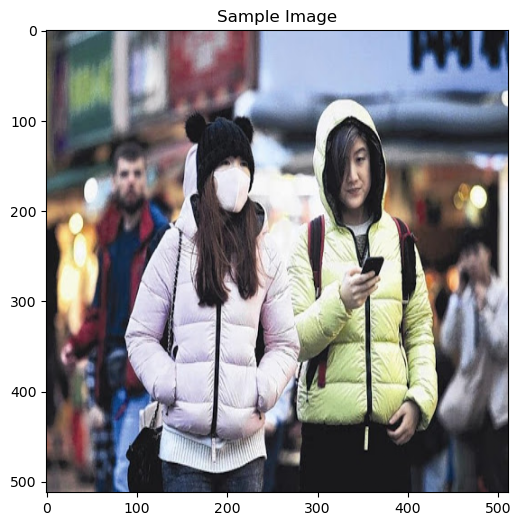

Target sample: {'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([2, 1, 2]), 'image_id': tensor([0])}


In [5]:
# Cell 3: Custom dataset class for face mask detection


class FaceMaskDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, label_map, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.label_map = label_map
        self.transforms = transforms
        
        all_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
        self.annotation_files = []
        for f in all_files:
            xml_path = os.path.join(annotations_dir, f)
            annotation = parse_annotation(xml_path, self.label_map)
            # Use shape[0] to check the number of boxes.
            if annotation["boxes"].shape[0] > 0:
                self.annotation_files.append(f)
                
        if len(self.annotation_files) == 0:
            raise AssertionError("No valid annotation files found with bounding boxes.")
                
    def __len__(self):
        return len(self.annotation_files)
    
    def __getitem__(self, idx):
        xml_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        annotation = parse_annotation(xml_path, self.label_map)
        
        tree = ET.parse(xml_path)
        root = tree.getroot()
        filename = root.find('filename').text.strip()
        img_path = os.path.join(self.images_dir, filename)
        img = Image.open(img_path).convert("RGB")
        
        target = {}
        target["boxes"] = torch.as_tensor(annotation["boxes"], dtype=torch.float32)
        target["labels"] = torch.as_tensor(annotation["labels"], dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

# Define transforms: resize images to a fixed size and convert them to tensor, then normalize.
# Note: Faster R-CNN models expect images in [0,1] range without normalization, 
# but you can add normalization if desired.
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
])

# Create the dataset
label_map = {
    "with_mask": 1,
    "without_mask": 2,
    "mask_weared_incorrect": 3
}
dataset = FaceMaskDataset(images_dir="images", annotations_dir="annotations",
                          label_map=label_map, transforms=transform)

print("Total samples in dataset:", len(dataset))

# Display one sample for verification
img_sample, target_sample = dataset[0]
plt.figure(figsize=(6,6))
plt.imshow(img_sample.permute(1,2,0))
plt.title("Sample Image")
plt.show()
print("Target sample:", target_sample)


In [6]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define transforms (resize to 224x224 and use ImageNet normalization)
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the full classification dataset.
classification_dataset = datasets.ImageFolder(root=output_dir, transform=classification_transform)

# Split dataset into 80% training and 20% testing.
dataset_size = len(classification_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(classification_dataset, [train_size, test_size])

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 3257, Test size: 815


In [7]:
print("Classes in dataset:", classification_dataset.classes)


Classes in dataset: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [8]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
torch.backends.cudnn.enabled = False  # Disable CuDNN for debugging purposes
torch.cuda.empty_cache()  # Clear the CUDA cache

import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# MobileNetV2 Model Definition
def get_mobilenet_model(num_classes=3, finetune_mode="fixed"):
    """Return a MobileNetV2 model modified for num_classes output.
       Use finetune_mode=="fixed" to freeze feature extractor layers,
       or "full" to fine-tune all layers."""
    model = models.mobilenet_v2(pretrained=True)
    if finetune_mode == "fixed":
        # Freeze the features layer
        for param in model.features.parameters():
            param.requires_grad = False
    # Replace the classifier: mobilenet_v2.last_channel is the input size to classifier
    in_features = model.last_channel
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )
    return model

# ResNet50 Model Definition
def get_resnet_model(num_classes=3, finetune_mode="fixed"):
    """Return a ResNet50 model modified for num_classes output.
       Use finetune_mode=="fixed" to freeze the base network,
       or "full" to fine-tune all layers."""
    model = models.resnet50(pretrained=True)
    if finetune_mode == "fixed":
        for param in model.parameters():
            param.requires_grad = False
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# EfficientNet (using efficientnet_b0) Model Definition
def get_efficientnet_model(num_classes=3, finetune_mode="fixed"):
    """Return an EfficientNet model modified for num_classes output.
       Use finetune_mode=="fixed" to freeze feature extractor layers,
       or "full" to fine-tune all layers."""
    model = models.efficientnet_b0(pretrained=True)
    if finetune_mode == "fixed":
        for param in model.features.parameters():
            param.requires_grad = False
    # The classifier in efficientnet_b0 is a Sequential container; update the second module
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# Faster R-CNN Model Definition for Face Mask Detection
def get_fasterrcnn_model(num_classes=4, finetune_mode="fixed"):
    """Return a Faster R-CNN model with a ResNet50-FPN backbone.
       For detection models using Faster R-CNN, the num_classes should
       be set to (number of object classes + 1 for background).
       Use finetune_mode to decide whether to freeze backbone layers."""
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    if finetune_mode == "fixed":
        # Freeze the backbone (feature extractor) parameters
        for param in model.backbone.parameters():
            param.requires_grad = False
    # Get the number of input features for the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the head with a new one (for 3 mask classes + 1 background)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create models for both fixed and full fine-tuning modes
# Classification Models
mobilenet_fixed    = get_mobilenet_model(num_classes=3, finetune_mode="fixed")
mobilenet_full     = get_mobilenet_model(num_classes=3, finetune_mode="full")
resnet_fixed       = get_resnet_model(num_classes=3, finetune_mode="fixed")
resnet_full        = get_resnet_model(num_classes=3, finetune_mode="full")
efficientnet_fixed = get_efficientnet_model(num_classes=3, finetune_mode="fixed")
efficientnet_full  = get_efficientnet_model(num_classes=3, finetune_mode="full")

# Object Detection Models (Faster R-CNN)
# Note: Faster R-CNN expects num_classes = number of classes + background (thus 4 here)
fasterrcnn_fixed   = get_fasterrcnn_model(num_classes=4, finetune_mode="fixed")
fasterrcnn_full    = get_fasterrcnn_model(num_classes=4, finetune_mode="full")

# Move all models to the selected device
mobilenet_fixed.to(device)
mobilenet_full.to(device)
resnet_fixed.to(device)
resnet_full.to(device)
efficientnet_fixed.to(device)
efficientnet_full.to(device)
fasterrcnn_fixed.to(device)
fasterrcnn_full.to(device)


c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can a

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
import torch.optim as optim
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
models = {
    "Full Model": fasterrcnn_full,
    "Fixed Backbone Model": fasterrcnn_fixed
}

num_epochs = 5

for model_name, detection_model in models.items():
    print(f"\n🔧 Training: {model_name}")
    detection_model.to(device)

    # Set optimizer over parameters that require gradients.
    params = [p for p in detection_model.parameters() if p.requires_grad]
    optimizer_detection = optim.Adam(params, lr=0.0001)

    for epoch in range(num_epochs):
        detection_model.train()
        epoch_loss = 0.0
        for images, targets in train_loader:
            valid_images = []
            valid_targets = []
            for img, tgt in zip(images, targets):
                # Check if tgt is a dict and tgt["boxes"] is not empty.
                if isinstance(tgt, dict) and tgt.get("boxes") is not None:
                    # Check if "boxes" is a tensor with at least one element and has a dimension > 0.
                    if tgt["boxes"].dim() > 0 and tgt["boxes"].numel() > 0:
                        valid_images.append(img.to(device))
                        valid_targets.append({k: v.to(device) for k, v in tgt.items()})
                    else:
                        # Optionally print debug info:
                        # print("Skipping sample with empty boxes.")
                        pass
                else:
                    # Optionally print debug info:
                    # print("Skipping sample: target is not a dict or missing 'boxes'.")
                    pass
            # If no valid samples in this batch, skip it.
            if len(valid_targets) == 0:
                continue

            loss_dict = detection_model(valid_images, valid_targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer_detection.zero_grad()
            losses.backward()
            optimizer_detection.step()

            epoch_loss += losses.item()
        
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")



🔧 Training: Full Model
[Full Model] Epoch 1/5, Loss: 0.0000
[Full Model] Epoch 2/5, Loss: 0.0000
[Full Model] Epoch 3/5, Loss: 0.0000
[Full Model] Epoch 4/5, Loss: 0.0000
[Full Model] Epoch 5/5, Loss: 0.0000

🔧 Training: Fixed Backbone Model
[Fixed Backbone Model] Epoch 1/5, Loss: 0.0000
[Fixed Backbone Model] Epoch 2/5, Loss: 0.0000
[Fixed Backbone Model] Epoch 3/5, Loss: 0.0000
[Fixed Backbone Model] Epoch 4/5, Loss: 0.0000
[Fixed Backbone Model] Epoch 5/5, Loss: 0.0000


In [10]:
from collections import Counter

all_labels = []
for _, label in classification_dataset:
    all_labels.append(label)
print("Unique labels in dataset:", Counter(all_labels))


Unique labels in dataset: Counter({1: 3232, 2: 717, 0: 123})


In [12]:
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define transforms for classification (resize to 224x224 and normalize as per ImageNet stats)
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load the classification dataset using ImageFolder.
# This assumes that your classification dataset directory ('classification_dataset')
# is organized with one subfolder per class:
# e.g., "with_mask", "without_mask", "incorrectly_wearing_mask".
classification_dataset = datasets.ImageFolder(root='classification_dataset', transform=classification_transform)

# Create a DataLoader for training (adjust batch_size and num_workers as needed)
classification_train_loader = DataLoader(classification_dataset, batch_size=32, shuffle=True, num_workers=4)

def train_classification_model(model, dataloader, num_epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.train()
    model.to(device)  # Ensure model is on GPU
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        print(f"[Classification] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}, Accuracy: {100.*correct/total:.2f}%")

# Example calls using the classification DataLoader:
# It is assumed that mobilenet_fixed, mobilenet_full, efficientnet_fixed, and efficientnet_full
# have been defined earlier in your notebook and are model instances already configured with num_classes=3.
print("Training MobileNetV2 (Fixed)")
train_classification_model(mobilenet_fixed, classification_train_loader, num_epochs=5)

print("Training MobileNetV2 (Full)")
train_classification_model(mobilenet_full, classification_train_loader, num_epochs=5)

print("Training EfficientNet (Fixed)")
train_classification_model(efficientnet_fixed, classification_train_loader, num_epochs=5)

print("Training EfficientNet (Full)")
train_classification_model(efficientnet_full, classification_train_loader, num_epochs=5)


Training MobileNetV2 (Fixed)
[Classification] Epoch 1/5, Loss: 0.4702, Accuracy: 81.09%
[Classification] Epoch 2/5, Loss: 0.4114, Accuracy: 84.36%
[Classification] Epoch 3/5, Loss: 0.3754, Accuracy: 86.81%
[Classification] Epoch 4/5, Loss: 0.3534, Accuracy: 88.70%
[Classification] Epoch 5/5, Loss: 0.3416, Accuracy: 88.56%
Training MobileNetV2 (Full)
[Classification] Epoch 1/5, Loss: 0.2380, Accuracy: 91.99%
[Classification] Epoch 2/5, Loss: 0.0757, Accuracy: 97.81%
[Classification] Epoch 3/5, Loss: 0.0373, Accuracy: 98.97%
[Classification] Epoch 4/5, Loss: 0.0244, Accuracy: 99.36%
[Classification] Epoch 5/5, Loss: 0.0165, Accuracy: 99.51%
Training EfficientNet (Fixed)
[Classification] Epoch 1/5, Loss: 0.7093, Accuracy: 75.12%
[Classification] Epoch 2/5, Loss: 0.5934, Accuracy: 78.61%
[Classification] Epoch 3/5, Loss: 0.5472, Accuracy: 79.32%
[Classification] Epoch 4/5, Loss: 0.5071, Accuracy: 80.23%
[Classification] Epoch 5/5, Loss: 0.4859, Accuracy: 81.43%
Training EfficientNet (Full)

Evaluating MobileNetV2 (Fixed)
Test Accuracy: 90.30%
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00       123
            with_mask       0.90      0.99      0.94      3232
         without_mask       0.90      0.66      0.76       717

             accuracy                           0.90      4072
            macro avg       0.60      0.55      0.57      4072
         weighted avg       0.88      0.90      0.88      4072



c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hamza\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

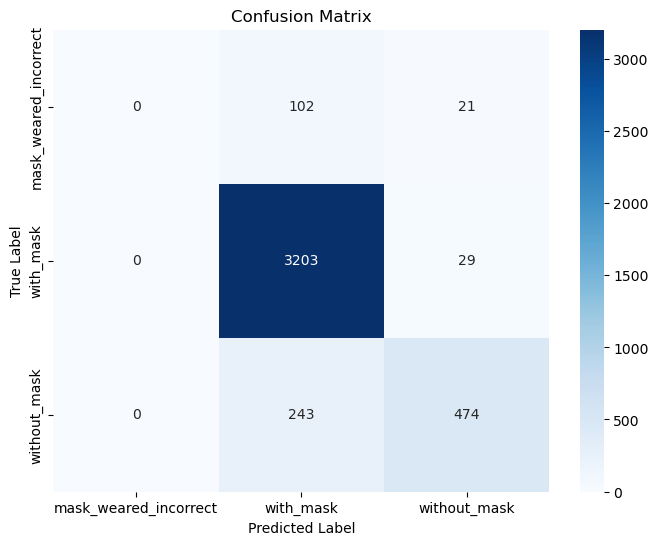

Evaluating MobileNetV2 (Full)
Test Accuracy: 99.95%
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      1.00      1.00       123
            with_mask       1.00      1.00      1.00      3232
         without_mask       1.00      1.00      1.00       717

             accuracy                           1.00      4072
            macro avg       1.00      1.00      1.00      4072
         weighted avg       1.00      1.00      1.00      4072



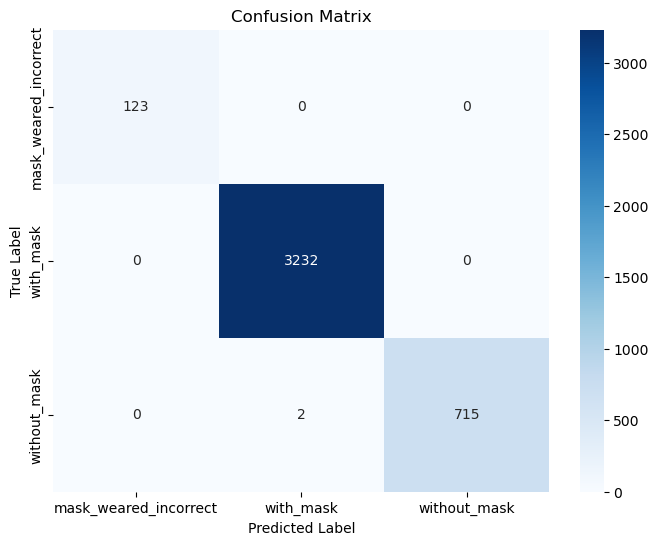

Evaluating EfficientNet (Fixed)
Test Accuracy: 83.23%
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00       123
            with_mask       0.83      0.99      0.90      3232
         without_mask       0.84      0.27      0.41       717

             accuracy                           0.83      4072
            macro avg       0.56      0.42      0.44      4072
         weighted avg       0.81      0.83      0.79      4072



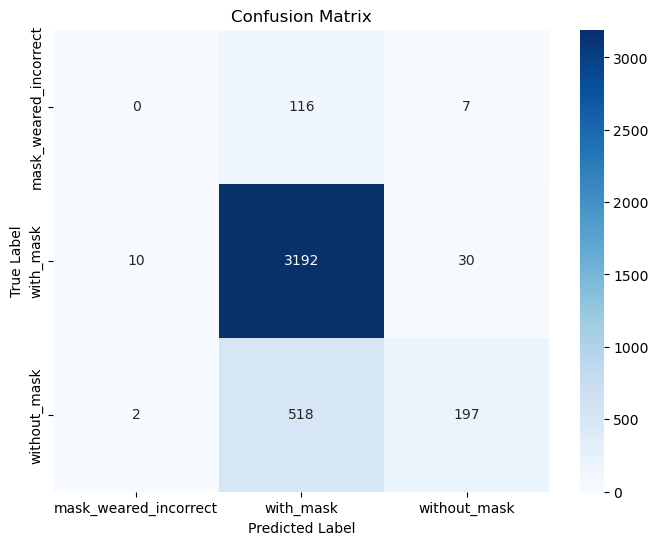

Evaluating EfficientNet (Full)
Test Accuracy: 99.93%
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.99      0.99      0.99       123
            with_mask       1.00      1.00      1.00      3232
         without_mask       1.00      1.00      1.00       717

             accuracy                           1.00      4072
            macro avg       1.00      1.00      1.00      4072
         weighted avg       1.00      1.00      1.00      4072



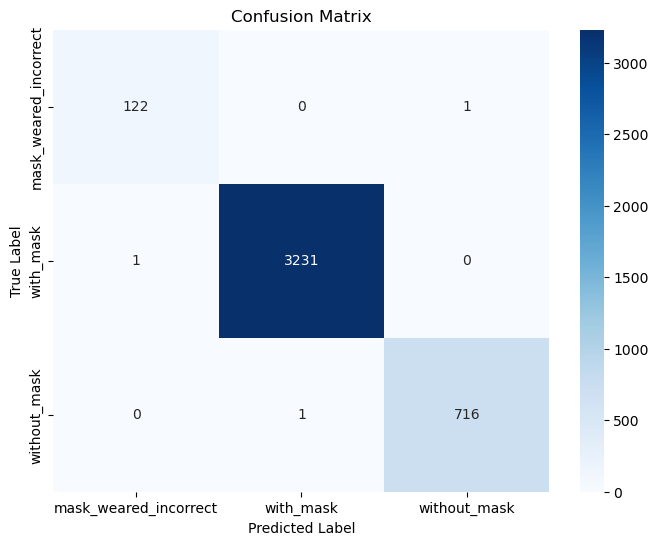

In [13]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define transforms (should be the same as for training)
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Assuming your test dataset is stored in a folder structure similar to training,
# using ImageFolder to create the test dataset.
classification_test_dataset = datasets.ImageFolder(root='classification_dataset', transform=classification_transform)
classification_test_loader = DataLoader(classification_test_dataset, batch_size=32, shuffle=False, num_workers=4)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_classification_model(model, dataloader):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            # For classification, assume outputs are logits (batch_size, num_classes)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean() * 100
    print("Test Accuracy: {:.2f}%".format(accuracy))
    
    # Get the class names from the dataset (ImageFolder returns classes sorted alphabetically)
    class_names = dataloader.dataset.dataset.classes if hasattr(dataloader.dataset, 'dataset') else dataloader.dataset.classes
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
    return accuracy

print("Evaluating MobileNetV2 (Fixed)")
acc_mobilenet_fixed = evaluate_classification_model(mobilenet_fixed, classification_test_loader)

print("Evaluating MobileNetV2 (Full)")
acc_mobilenet_full = evaluate_classification_model(mobilenet_full, classification_test_loader)

print("Evaluating EfficientNet (Fixed)")
acc_efficientnet_fixed = evaluate_classification_model(efficientnet_fixed, classification_test_loader)

print("Evaluating EfficientNet (Full)")
acc_efficientnet_full = evaluate_classification_model(efficientnet_full, classification_test_loader)


In [50]:
import cv2
import torch
import torchvision.transforms as transforms
import numpy as np

# Use your previously defined model (for instance, mobilenet_fixed)
# Make sure the model is set to evaluation mode and on the proper device.
model = mobilenet_fixed  
model.eval()
model.to(device)

# If using Iriun Webcam, replace 0 with your stream URL, e.g.,
# cap = cv2.VideoCapture('http://192.168.1.10:8080/video')
cap = cv2.VideoCapture(0)

# Load OpenCV's Haar cascade for face detection.
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define a transformation pipeline for the face region (must match training transforms)
face_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Define a label map for the predicted indices.
# Since your training labels (after adjustment) are zero-indexed:
# 0 -> with_mask, 1 -> without_mask, 2 -> mask_weared_incorrect
labels = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

print("Starting real-time face mask detection. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Convert the frame to grayscale for face detection.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame.
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract the face region.
        face_roi = frame[y:y+h, x:x+w]
        # If ROI is empty, skip this face.
        if face_roi.size == 0:
            continue
        
        # Apply transforms on the face region.
        face_input = face_transform(face_roi)
        face_input = face_input.unsqueeze(0).to(device)
        
        # Get prediction from the model.
        with torch.no_grad():
            outputs = model(face_input)
            _, pred = torch.max(outputs, 1)
            pred = pred.item()

        # Set bounding box color: Green if "with_mask", Red otherwise.
        if labels[pred] == 'with_mask':
            color = (0, 255, 0)  # green
        else:
            color = (0, 0, 255)  # red
            
        # Draw bounding box and label text on the original frame.
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, labels[pred], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the resulting frame.
    cv2.imshow('Face Mask Detection', frame)

    # Press 'q' key to exit the loop.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup.
cap.release()
cv2.destroyAllWindows()


Train size: 3159, Test size: 790
